# Transactions Fraud Detection

**Authors:** [Peter Macinec](https://github.com/pmacinec), [Timotej Zatko](https://github.com/timzatko)

## Nature Inspired Algorithms for Feature Selection

- all used on DT, compared with baseline 

We will train the model with selected features on the whole dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

from NiaPy.task import StoppingTask, OptimizationType
from NiaPy.algorithms.basic import GreyWolfOptimizer, FireflyAlgorithm, GeneticAlgorithm, \
    BatAlgorithm, ParticleSwarmOptimization

from src.algorithms.grey_wolf_optimizer_multiprocessing import GreyWolfOptimizerMultiprocessing

from src.dataset import load_processed_data
from src.data_balancing import random_undersample
from src.evaluation import custom_classification_report

from src.classification_benchmark import ClassificationBenchmark

### Load the data

In [3]:
x_train, y_train, x_test, y_test = load_processed_data()

Number of records:
  x_train - 472432
  y_train - 472432
  x_test - 118108
  y_test - 118108


In [4]:
x_train, y_train = random_undersample(x_train, y_train)
len(x_train), len(y_train)

(32842, 32842)

### Setup classification benchmark

In [5]:
def model_fn():
    return DecisionTreeClassifier(random_state=42)

In [6]:
columns_count = len(x_train.columns)

_x_train, _x_val, _y_train, _y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

benchmark = ClassificationBenchmark(
    model_fn,
    roc_auc_score,
    _x_train,
    _y_train,
    _x_val,
    _y_val
)

In [7]:
def optimize(benchmark, algorithm, nGEN, num_runs = 5):
    """
    Optimize task with provided algorithm.
    
    :param benchmark: NiaPy.Benchmark to optimize.
    :param algorithm: algorithm object to use for optimization task.
    :param nGEN: number of generations.
    :param num_runs: number of algorithm runs (defaults to 5).
    """
    best_columns = None
    best_score = 0
    
    for i in range(num_runs):
        # when using OptimizationType.MAXIMIZATION, the library will fail
        # we use OptimizationType.MINIMIZATION instead and invert the score
        task = StoppingTask(
            D=benchmark.get_length(),
            nGEN=nGEN,
            optType=OptimizationType.MINIMIZATION,
            benchmark=benchmark
        )
        
        solution_vec, score = algorithm.run(task=task)    
        
        # invert the score
        score = 1 - score
        columns = benchmark.select_columns(solution_vec)
        
        print('--------------')
        print(f'Run {i + 1}')
        print('--------------')
        print(f'Score: {score}')
        print(f'Number of features selected: {len(columns)}\n')
        print('\n')
        
        if score > best_score:
            best_score = score
            best_columns = columns

    print(f'\nBest score of {num_runs} runs: {best_score}')
    print(f'Number of features selected: {len(best_columns)}')
            
    return best_columns

### Grey Wolf Optimization (GWO)

Find the optimal combination of columns.

In [8]:
%%time

columns = optimize(benchmark, GreyWolfOptimizerMultiprocessing(nodes=4, NP=25), 100)

--------------
Run 1
--------------
Score: 0.7921881236525397
Number of features selected: 130



--------------
Run 2
--------------
Score: 0.7890883618738991
Number of features selected: 117



--------------
Run 3
--------------
Score: 0.7909730908535166
Number of features selected: 125



--------------
Run 4
--------------
Score: 0.7915789379971601
Number of features selected: 126



--------------
Run 5
--------------
Score: 0.7875847796508064
Number of features selected: 122




Best score of 5 runs: 0.7921881236525397
Number of features selected: 130
CPU times: user 12min 19s, sys: 5min 53s, total: 18min 12s
Wall time: 1h 12min 33s


not fraud
precision: 0.7651010837299984
recall: 0.9897636900704385
f1-score: 0.8630514250616684
support: 88020


is fraud
precision: 0.7876001885902876
recall: 0.11104094655676681
f1-score: 0.19464025633556656
support: 30088


accuracy: 0.7659091678802452


macro avg
precision: 0.776350636160143
recall: 0.5504023183136026
f1-score: 0.5288458406986175
support: 118108


weighted avg
precision: 0.7708327282167088
recall: 0.7659091678802452
f1-score: 0.6927737533998762
support: 118108


Area Under the Receiver Operating Characteristic Curve (ROC AUC)
Score: 0.776350636160143




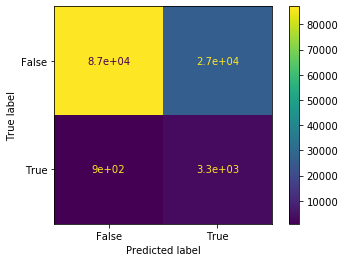

In [9]:
clf = model_fn()
clf = clf.fit(x_train[columns], y_train)
custom_classification_report(clf, x_test[columns], y_test)

We found the best solution from 5 independent runs of GWO algorithm. During every run we captured a different solution. For the final submission, we probably would not like to use "the best one", because we would like to have some variance. Maybe we can try to merge these solution together.

### Firefly Algorithm (FA)

In [10]:
%%time

columns = optimize(benchmark, FireflyAlgorithm(), 100)

--------------
Run 1
--------------
Score: 0.7984354528431508
Number of features selected: 118



--------------
Run 2
--------------
Score: 0.7980325593921238
Number of features selected: 119



--------------
Run 3
--------------
Score: 0.8007932767566878
Number of features selected: 130



--------------
Run 4
--------------
Score: 0.7998601163582624
Number of features selected: 110



--------------
Run 5
--------------
Score: 0.8013894329426533
Number of features selected: 128




Best score of 5 runs: 0.8013894329426533
Number of features selected: 128
CPU times: user 1h 54min 58s, sys: 0 ns, total: 1h 54min 58s
Wall time: 1h 54min 52s


not fraud
precision: 0.8008624172272671
recall: 0.9902163054336968
f1-score: 0.8855300595266996
support: 92092


is fraud
precision: 0.7876001885902876
recall: 0.12842097170971709
f1-score: 0.22083415956110777
support: 26016


accuracy: 0.8003860873099198


macro avg
precision: 0.7942313029087773
recall: 0.5593186385717069
f1-score: 0.5531821095439037
support: 118108


weighted avg
precision: 0.7979411067299286
recall: 0.8003860873099198
f1-score: 0.7391155191610611
support: 118108


Area Under the Receiver Operating Characteristic Curve (ROC AUC)
Score: 0.7942313029087774




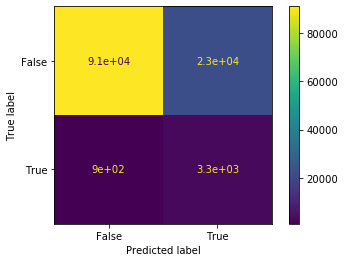

In [11]:
clf = model_fn()
clf = clf.fit(x_train[columns], y_train)
custom_classification_report(clf, x_test[columns], y_test)

### Genetic Algorithm (GA)

In [12]:
%%time

columns = optimize(benchmark, GeneticAlgorithm(), 100)

--------------
Run 1
--------------
Score: 0.7991208678498352
Number of features selected: 125



--------------
Run 2
--------------
Score: 0.8007835857990097
Number of features selected: 121



--------------
Run 3
--------------
Score: 0.8000473512247888
Number of features selected: 127



--------------
Run 4
--------------
Score: 0.8020460996538334
Number of features selected: 134



--------------
Run 5
--------------
Score: 0.7982515564883605
Number of features selected: 117




Best score of 5 runs: 0.8020460996538334
Number of features selected: 134
CPU times: user 2h 30min 52s, sys: 2.13 s, total: 2h 30min 54s
Wall time: 2h 30min 46s


not fraud
precision: 0.7989917973758629
recall: 0.9895904715287975
f1-score: 0.8841356455993897
support: 91935


is fraud
precision: 0.7743988684582744
recall: 0.12551102280976578
f1-score: 0.21601183626500084
support: 26173


accuracy: 0.7981085108544722


macro avg
precision: 0.7866953329170687
recall: 0.5575507471692817
f1-score: 0.5500737409321953
support: 118108


weighted avg
precision: 0.7935419486902527
recall: 0.7981085108544722
f1-score: 0.7360778979302314
support: 118108


Area Under the Receiver Operating Characteristic Curve (ROC AUC)
Score: 0.7866953329170687




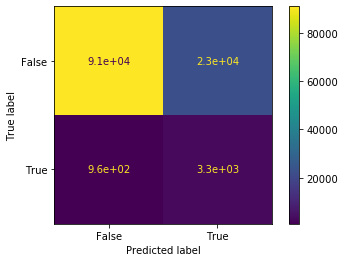

In [13]:
clf = model_fn()
clf = clf.fit(x_train[columns], y_train)
custom_classification_report(clf, x_test[columns], y_test)

### Particle Swarm Optimization (PSO)

In [14]:
%%time

columns = optimize(benchmark, ParticleSwarmOptimization(), 100)

--------------
Run 1
--------------
Score: 0.8047336016012985
Number of features selected: 121



--------------
Run 2
--------------
Score: 0.8072659554894778
Number of features selected: 97



--------------
Run 3
--------------
Score: 0.7987784849240229
Number of features selected: 121



--------------
Run 4
--------------
Score: 0.8053681970404465
Number of features selected: 130



--------------
Run 5
--------------
Score: 0.8096134392902768
Number of features selected: 121




Best score of 5 runs: 0.8096134392902768
Number of features selected: 121
CPU times: user 2h 25min 24s, sys: 2.66 s, total: 2h 25min 27s
Wall time: 2h 25min 19s


not fraud
precision: 0.800221312771152
recall: 0.9904884067265988
f1-score: 0.8852466979825997
support: 91993


is fraud
precision: 0.7937293729372937
recall: 0.1289297338694237
f1-score: 0.2218269262443588
support: 26115


accuracy: 0.7999881464422393


macro avg
precision: 0.7969753428542229
recall: 0.5597090702980112
f1-score: 0.5535368121134793
support: 118108


weighted avg
precision: 0.7987858722526333
recall: 0.7999881464422393
f1-score: 0.7385571651910516
support: 118108


Area Under the Receiver Operating Characteristic Curve (ROC AUC)
Score: 0.7969753428542229




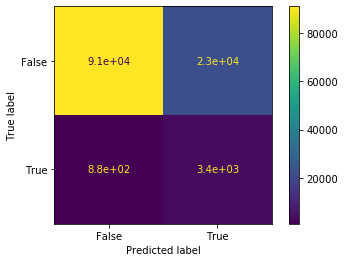

In [15]:
clf = model_fn()
clf = clf.fit(x_train[columns], y_train)
custom_classification_report(clf, x_test[columns], y_test)

### Bat Algorithm (BA)

In [8]:
%%time

columns = optimize(benchmark, BatAlgorithm(), 100)

--------------
Run 1
--------------
Score: 0.8072656309119478
Number of features selected: 119



--------------
Run 2
--------------
Score: 0.7969729992299166
Number of features selected: 117



--------------
Run 3
--------------
Score: 0.8026776811587752
Number of features selected: 118



--------------
Run 4
--------------
Score: 0.8094486002733129
Number of features selected: 105



--------------
Run 5
--------------
Score: 0.8149406375518768
Number of features selected: 118




Best score of 5 runs: 0.8149406375518768
Number of features selected: 118
CPU times: user 3h 50min 16s, sys: 1.22 s, total: 3h 50min 17s
Wall time: 3h 50min 17s


not fraud
precision: 0.8073876310751233
recall: 0.990721482838515
f1-score: 0.8897082661943957
support: 92795


is fraud
precision: 0.7970297029702971
recall: 0.13356773199541738
f1-score: 0.22879377431906617
support: 25313


accuracy: 0.8070156128289362


macro avg
precision: 0.8022086670227102
recall: 0.5621446074169663
f1-score: 0.5592510202567309
support: 118108


weighted avg
precision: 0.8051677117291225
recall: 0.8070156128289362
f1-score: 0.7480605494195776
support: 118108


Area Under the Receiver Operating Characteristic Curve (ROC AUC)
Score: 0.8022086670227102




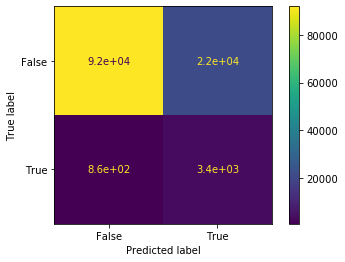

In [9]:
clf = model_fn()
clf = clf.fit(x_train[columns], y_train)
custom_classification_report(clf, x_test[columns], y_test)

### Conclusion

__Grey Wolf Optimization__

Score (ROC AUC): 0.776

__Firefly Algorithm__

Score (ROC AUC): 0.794
    
__Genetic Algorithm__

Score (ROC AUC): 0.786
    
__Particle Swarm Optimization__

Score (ROC AUC): 0.796
    
__Bat Algorithm__

Score (ROC AUC): 0.802